In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import json
import os
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from argparse import Namespace
import tqdm
import re

In [3]:
"""
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
"""

'\n!sudo apt-get install -y fonts-nanum\n!sudo fc-cache -fv\n!rm ~/.cache/matplotlib -rf\n'

In [4]:
plt.rc('font', family='NanumBarunGothic')

# Vocabulary, SequenceVocabulary

In [5]:
class Vocabulary():
  def __init__(self, token_to_idx=None):
    if token_to_idx is None:
      token_to_idx = {}
    self._token_to_idx = token_to_idx
    self._idx_to_token = {idx:token for token, idx in self._token_to_idx.items()}

  def to_serializable(self):
    return {"token_to_idx": self._token_to_idx}

  @classmethod
  def from_serializable(cls, contents):
    return cls(**contents)

  def add_token(self, token):
    if token in self._token_to_idx:
      index = self._token_to_idx[token]
    else:
      index = len(self._token_to_idx)
      self._token_to_idx[token] = index
      self._idx_to_token[index] = token
    return index

  def add_many(self, tokens):
    return [self.add_token(token) for token in tokens]

  def lookup_token(self,token):
    return self._token_to_idx[token]

  def lookup_index(self, index):
    if index not in self._idx_to_token:
      raise KeyError("the index (%d) is not in the Vocabulary" % index)
    return self._idx_to_token[index]

  def __str__(self):
    return "<Vocabulary(size=%d)>" % len(self)

  def __len__(self):
    return len(self._token_to_idx)

In [6]:
class SequenceVocabulary(Vocabulary): #상속
  def __init__(self, token_to_idx= None, unk_token="<UNK>",
               mask_token="<MASK>", begin_seq_token="<BEGIN>",
               end_seq_token="<END>"):
    super(SequenceVocabulary, self).__init__(token_to_idx)

    self._mask_token = mask_token
    self._unk_token = unk_token
    self._begin_seq_token = begin_seq_token
    self._end_seq_token = end_seq_token

    self.mask_index = self.add_token(self._mask_token)
    self.unk_index = self.add_token(self._unk_token)
    self.begin_seq_index = self.add_token(self._begin_seq_token)
    self.end_seq_index = self.add_token(self._end_seq_token)

  def to_serializable(self):
    contents = super(SequenceVocabulary, self).to_serializable()
    contents.update(
        {
            "unk_token": self._unk_token,
            "mask_token": self._mask_token,
            "begin_seq_token": self._begin_seq_token,
            "end_seq_token": self._end_seq_token
        }
    )
    return contents

  def lookup_token(self, token):
    if self.unk_index >= 0:
      return self._token_to_idx.get(token, self.unk_index)
    else:
      return self._token_to_idx[token]

# NMTVetorizer
- 지금까지 해온 Vectorizer의 두배(source-target)문장에 대해서 vectorize를 해야해 높은 복잡도를 가짐.


In [7]:
class NMTVectorizer():
  def __init__(self, source_vocab, target_vocab, max_source_length, max_target_length):
    self.source_vocab = source_vocab
    self.target_vocab = target_vocab

    self.max_source_length = max_source_length
    self.max_target_length = max_target_length

  def _vectorize(self, indices, vector_length=-1, mask_index=0):
    if vector_length < 0:
      vector_length = len(indices)

    vector = np.zeros(vector_length, dtype=np.int64)
    vector[:len(indices)] = indices
    vector[len(indices):] = mask_index

    return vector
  def _get_source_indices(self, text):
    indices = [self.source_vocab.begin_seq_index]
    indices.extend(self.source_vocab.lookup_token(token) for token in text.split(" "))
    indices.append(self.source_vocab.end_seq_index)
    return indices

  def _get_target_indices(self, text):
    indices = [self.target_vocab.lookup_token(token) for token in text.split()]
    x_indices = [self.target_vocab.begin_seq_index] + indices
    y_indices = indices + [self.target_vocab.end_seq_index]
    return x_indices, y_indices

  def vectorize(self, source_text, target_text, use_dataset_max_lengths=True):
    source_vector_length = -1
    target_vector_length = -1

    if use_dataset_max_lengths:
      source_vector_length = self.max_source_length + 2
      target_vector_length = self.max_target_length + 1

    source_indices = self._get_source_indices(source_text)
    source_vector = self._vectorize(
        source_indices,
        vector_length=source_vector_length,
        mask_index=self.source_vocab.mask_index
    )

    target_x_indices, target_y_indices = self._get_target_indices(target_text)
    target_x_vector = self._vectorize(
        target_x_indices,
        vector_length=target_vector_length,
        mask_index=self.target_vocab.mask_index
    )
    target_y_vector = self._vectorize(
        target_y_indices,
        vector_length=target_vector_length,
        mask_index=self.target_vocab.mask_index
    )

    return {
        "source_vector": source_vector,
        "target_x_vector": target_x_vector,
        "target_y_vector": target_y_vector,
        "source_length": len(source_indices)
    }

  @classmethod
  def from_dataframe(cls, bitext_df):
    source_vocab = SequenceVocabulary()
    target_vocab = SequenceVocabulary()

    max_source_length = 0
    max_target_length = 0

    for _, row in bitext_df.iterrows():
      source_tokens = row["source_language"].split()
      if len(source_tokens) > max_source_length:
        max_source_length = len(source_tokens)
      for token in source_tokens:
        source_vocab.add_token(token)

      target_tokens = row["target_language"].split()
      if len(target_tokens) > max_target_length:
        max_target_length = len(target_tokens)
      for token in target_tokens:
        target_vocab.add_token(token)

    return cls(source_vocab, target_vocab, max_source_length, max_target_length)

  @classmethod
  def from_serializable(cls, contents):
    source_vocab = SequenceVocabulary().from_serializable(contents["source_vocab"])
    target_vocab = SequenceVocabulary().from_serializable(contents["target_vocab"])

    return cls(source_vocab = source_vocab,
               target_vocab = target_vocab,
               max_source_length = contents["max_source_length"],
               max_target_length = contents["max_target_length"])

  def to_serializable(self):
    return {
        "source_vocab": self.source_vocab.to_serializable(),
        "target_vocab": self.target_vocab.to_serializable(),
        "max_source_length": self.max_source_length,
        "max_target_length": self.max_target_length
    }

# Dataset

In [8]:
class NMTDataset(Dataset):
  def __init__(self, text_df, vectorizer):
    self.text_df = text_df
    self._vectorizer = vectorizer

    self.train_df = self.text_df[self.text_df.split=='train']
    self.train_size = len(self.train_df)
    self.val_df = self.text_df[self.text_df.split=='val']
    self.validation_size = len(self.val_df)
    self.test_df = self.text_df[self.text_df.split=='test']
    self.test_size = len(self.test_df)

    self._lookup_dict = {'train': (self.train_df, self.train_size),
                          'val': (self.val_df, self.validation_size),
                          'test': (self.test_df, self.test_size)}
    self.set_split('train')

  @classmethod
  def load_dataset_and_make_vectorizer(cls, dataset_csv):
    text_df = pd.read_csv(dataset_csv)
    train_subset = text_df[text_df.split=="train"]
    return cls(text_df, NMTVectorizer.from_dataframe(train_subset))

  @classmethod
  def load_dataset_and_load_vectorizer(cls, dataset_csv, vectorizer_filepath):
    text_df = pd.read_csv(dataset_csv)
    vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
    return cls(text_df, vectorizer)

  @staticmethod
  def load_vectorizer_only(vectorizer_filepath):
    with open(vectorizer_filepath) as fp:
      return NMTVectorizer.from_serializable(json.load(fp))

  def save_vectorizer(self, vectorizer_filepath):
    with open(vectorizer_filepath, "w") as fp:
      json.dump(self._vectorizer.to_serializable(), fp)

  def get_vectorizer(self):
    return self._vectorizer

  def set_split(self, split="train"):
    self._target_split = split
    self._target_df, self._target_size = self._lookup_dict[split]

  def __len__(self):
    return self._target_size

  def __getitem__(self, index):
    row = self._target_df.iloc[index]
    vector_dict = self._vectorizer.vectorize(row.source_language, row.target_language)
    return {
        "x_source": vector_dict["source_vector"],
        "x_target": vector_dict["target_x_vector"],
        "y_target": vector_dict["target_y_vector"],
        "x_source_length": vector_dict["source_length"]
    }

  def get_num_batches(self, batch_size):
    return len(self) // batch_size

In [9]:
def generate_nmt_batches(dataset, batch_size, shuffle=True,
                         drop_last=True, device="cpu"):
  dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                          shuffle=shuffle, drop_last=drop_last)

  for data_dict in dataloader:
    lengths = data_dict["x_source_length"].numpy()
    sorted_length_indices = lengths.argsort()[::-1].tolist()

    out_data_dict = {}
    for name, tensor in data_dict.items():
      out_data_dict[name] = data_dict[name][sorted_length_indices].to(device)
    yield out_data_dict

# Model - Neural Machine Translation Model

## NMT Encoder

In [10]:
class NMTEncoder(nn.Module):
  def __init__(self, num_embeddings, embedding_size, rnn_hidden_size):
    super(NMTEncoder, self).__init__()

    self.source_embedding = nn.Embedding(num_embeddings, embedding_size, padding_idx=0)
    self.birnn = nn.GRU(embedding_size, rnn_hidden_size, bidirectional=True, batch_first=True)
  def forward(self, x_source, x_lengths):
    # x_source (batch_size, seq_size) -> 정수 맵핑
    # x_lengths (batch_size, )

    x_embedded = self.source_embedding(x_source) # (batch_size, seq_size, embedding_size)

    x_packed = pack_padded_sequence(x_embedded, x_lengths.detach().cpu().numpy(),
                                   batch_first = True) # (number_items, embedding_size)
    """
    number_items = sum(x_lengths)
    """

    x_birnn_out, x_birnn_h = self.birnn(x_packed) # (number_items, embedding_size), (num_rnn, batch_size, feature_size)
    x_birnn_h = x_birnn_h.permute(1, 0, 2) # (batch_size, num_rnn, feature_size)
    """
    1. x_birnn_out
      torch.nn.utils.rnn.PackedSequence has been given as the input,
      the output will also be a packed sequence.
    2.x_birnn_h
      num_rnn = D * num_layers
      D = 2 for bidirectional, num_layers = the number of stacked RNN layers.
      In this case, num_rnn = 2
    """

    x_birnn_h = x_birnn_h.contiguous().view(x_birnn_h.size(0), -1) # (batch_size, num_rnn * feature_size)

    x_unpacked, _ = pad_packed_sequence(x_birnn_out, batch_first=True)
    # (batch_size, seq_size, D * rnn_hidden_size), D = 2 for bidirectional

    return x_unpacked, x_birnn_h #(batch_size, seq_sizem D * rnn_hidden_size), (batch_size, num_rnn * feature_size)

## Attention Mechanism

In [11]:
# query_vector.shape (batch_size, vector_size) --> decoder_size = encoder_size * 2 (cause' encoder uses bi-RNN architecture)
def verbose_attention(encoder_state_vectors, query_vector):
  batch_size, num_vectors, vector_size = encoder_state_vectors.size() # (batch_size, num_vectors, vector_size)

  # dot-product 계산
  vector_scores = \
    torch.sum(encoder_state_vectors * query_vector.view(batch_size, 1, vector_size), dim = 2) # (batch_size, num_vectors)

  vector_probabilities = F.softmax(vector_scores, dim = 1) # (batch_size, num_vectors)
  weighted_vectors = \
    encoder_state_vectors * vector_probabilities.view(batch_size, num_vectors, 1) # (batch_size, num_vectors, vector_size) <- broadcasting

  context_vectors = torch.sum(weighted_vectors, dim=1) # 가중합. (batch_size, 1, vector_size)
  return context_vectors, vector_probabilities, vector_scores # (batch_size, vector_size), (batch_size, num_vectors)

def terse_attention(encoder_state_vectors, query_vector): # (batch_size, num_vectors, vector_size), (batch_size, vector_size)
  vector_scores = torch.matmul(encoder_state_vectors,
                               # 3차원 끼리의 곱의 첫번째 dimensiong은 batch_dimesion 취급된다는점. 매우 주의 해야함.
                               query_vector.unsqueeze(dim=2)).squeeze() # (batch_size, num_vectors, vector_size) * (batch_size, vector_size, 1) ->  ((batch_size), num_vectors, 1)
                               # after squeeze -> (batch_size, num_vectors)
  vector_probabilities = F.softmax(vector_scores, dim=-1) # (batch_size, num_vectors)

  context_vectors = torch.matmul(encoder_state_vectors.transpose(-2, -1), # (batch_size, vector_size, num_vectors)
                                 vector_probabilities.unsqueeze(dim=2)).squeeze() # (batch_size, num_vectors, 1)
                                 # batch_size (vector_size, num_vectors) * (num_vectors, 1) -> (batch_size, vectorsize, 1) -> (batch_size, vector_size)
  return context_vectors, vector_probabilities # (batch_size, vector_size), (batch_size, num_vectors)

In [12]:
"""
batch = torch.randn(32, 20, 50)
query = torch.randn(32, 50)
cv, vps = terse_attention(batch, query)
print(cv.shape)
print(vps.shape)
"""

'\nbatch = torch.randn(32, 20, 50)\nquery = torch.randn(32, 50)\ncv, vps = terse_attention(batch, query)\nprint(cv.shape)\nprint(vps.shape)\n'

## NMT Decoder

In [13]:
class NMTDecoder(nn.Module):
  def __init__(self, num_embeddings, embedding_size, rnn_hidden_size, bos_index):
    super(NMTDecoder, self).__init__()
    self._rnn_hidden_size = rnn_hidden_size
    self.target_embedding = nn.Embedding(num_embeddings=num_embeddings,
                                         embedding_dim=embedding_size,
                                         padding_idx=0)
    self.gru_cell = nn.GRUCell(embedding_size + rnn_hidden_size,
                               rnn_hidden_size)
    self.hidden_map = nn.Linear(rnn_hidden_size, rnn_hidden_size)
    self.classifier = nn.Linear(rnn_hidden_size * 2, num_embeddings)
    self.bos_index = bos_index

  def _init_indices(self, batch_size):
    return torch.ones(batch_size, dtype=torch.int64) * self.bos_index

  def _init_context_vectors(self, batch_size):
    return torch.zeros(batch_size, self._rnn_hidden_size)

  def forward(self, encoder_state, initial_hidden_state, target_sequence):
    target_sequence = target_sequence.permute(1, 0)
    output_sequence_size = target_sequence.size(0)

    h_t = self.hidden_map(initial_hidden_state)
    batch_size = encoder_state.size(0)
    context_vectors = self._init_context_vectors(batch_size)
    y_t_index = self._init_indices(batch_size)

    h_t = h_t.to(encoder_state.device)
    y_t_index = y_t_index.to(encoder_state.device)
    context_vectors = context_vectors.to(encoder_state.device)

    output_vectors = []
    self._cached_p_attn = []
    self._cached_ht = []
    self._cached_decoder_state = encoder_state.cpu().detach().numpy()

    for i in range(output_sequence_size):
      y_t_index = target_sequence[i]

      y_input_vector = self.target_embedding(y_t_index)
      rnn_input = torch.cat([y_input_vector, context_vectors], dim=1)

      h_t = self.gru_cell(rnn_input, h_t)
      self._cached_ht.append(h_t.cpu().detach().numpy())

      context_vectors, p_attn, _ = verbose_attention(encoder_state_vectors=encoder_state,
                                                           query_vector=h_t)

      self._cached_p_attn.append(p_attn.cpu().detach().numpy())

      prediction_vector = torch.cat((context_vectors, h_t), dim=1)
      score_for_y_t_index = self.classifier(F.dropout(prediction_vector, 0.3))

      output_vectors.append(score_for_y_t_index)

    output_vectors = torch.stack(output_vectors).permute(1, 0, 2)

    return output_vectors


## NMT Seq2Seq

In [14]:
class NMTModel(nn.Module):
  def __init__(self, source_vocab_size, source_embedding_size,
             target_vocab_size, target_embedding_size, encoding_size,
             target_bos_index):
    super(NMTModel, self).__init__()
    self.encoder = NMTEncoder(num_embeddings=source_vocab_size,
                              embedding_size=source_embedding_size,
                              rnn_hidden_size=encoding_size)
    decoding_size = encoding_size * 2
    self.decoder = NMTDecoder(num_embeddings=target_vocab_size,
                              embedding_size=target_embedding_size,
                              rnn_hidden_size=decoding_size,
                              bos_index=target_bos_index)
  def forward(self, x_source, x_source_lengths, target_sequence):
    encoder_state, final_hidden_states = self.encoder(x_source, x_source_lengths)
    decoded_states = self.decoder(encoder_state=encoder_state,
                                  initial_hidden_state=final_hidden_states,
                                  target_sequence=target_sequence)

    return decoded_states

# 모델훈련과 기록함수


In [15]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """후련 상태 업데이트합니다.

    콤포넌트:
     - 조기 종료: 과대 적합 방지
     - 모델 체크포인트: 더 나은 모델을 저장합니다

    :param args: 메인 매개변수
    :param model: 훈련할 모델
    :param train_state: 훈련 상태를 담은 딕셔너리
    :returns:
        새로운 훈련 상태
    """

    # 적어도 한 번 모델을 저장합니다
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # 성능이 향상되면 모델을 저장합니다
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # 손실이 나빠지면
        if loss_t >= train_state["early_stopping_best_val"]:
            # 조기 종료 단계 업데이트
            train_state['early_stopping_step'] += 1
        # 손실이 감소하면
        else:
            # 최상의 모델 저장
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # 조기 종료 단계 재설정
            train_state['early_stopping_step'] = 0

        # 조기 종료 여부 확인
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def normalize_sizes(y_pred, y_true):
    """텐서 크기 정규화

    매개변수:
        y_pred (torch.Tensor): 모델의 출력
            3차원 텐서이면 행렬로 변환합니다.
        y_true (torch.Tensor): 타깃 예측
            행렬이면 벡터로 변환합니다.
    """
    if len(y_pred.size()) == 3:
        y_pred = y_pred.contiguous().view(-1, y_pred.size(2))
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)
    return y_pred, y_true

def compute_accuracy(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)

    _, y_pred_indices = y_pred.max(dim=1)

    correct_indices = torch.eq(y_pred_indices, y_true).float()
    valid_indices = torch.ne(y_true, mask_index).float()

    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = valid_indices.sum().item()

    return n_correct / n_valid * 100

def sequence_loss(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    return F.cross_entropy(y_pred, y_true, ignore_index=mask_index)

# Parameters For Training

In [16]:
base_path = "/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter8_Seq_Modeling_Advanced/kor-eng-project/"
args = Namespace(dataset_csv=base_path + "data/ted-eng-kor.csv",
                 vectorizer_file="ted_no_scheduling_vectorizer.json",
                 model_state_file="ted_no_scheduling_model.pth",
                 save_dir=base_path + "model_storage/ted",
                 train_state_file = base_path + "data/dict/ted-no-sampling.pickle",
                 reload_from_files=False,
                 expand_filepaths_to_save_dir=True,
                 cuda=True,
                 seed=1337,
                 learning_rate=5e-4,
                 batch_size=64,
                 num_epochs=100,
                 early_stopping_criteria=5,
                 source_embedding_size=64,
                 target_embedding_size=64,
                 encoding_size=64,
                 catch_keyboard_interrupt=True)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)

    print("파일 경로: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))

# CUDA 체크
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

print("CUDA 사용 여부: {}".format(args.cuda))

# 재현성을 위해 시드 설정
set_seed_everywhere(args.seed, args.cuda)

# 디렉토리 처리
handle_dirs(args.save_dir)

파일 경로: 
	/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter8_Seq_Modeling_Advanced/kor-eng-project/model_storage/ted/ted_no_scheduling_vectorizer.json
	/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter8_Seq_Modeling_Advanced/kor-eng-project/model_storage/ted/ted_no_scheduling_model.pth
CUDA 사용 여부: True


# Initialization(Load Dataset and Make Vectorizer)

In [17]:
if args.reload_from_files and os.path.exists(args.vectorizer_file):
    # 체크포인트를 로드합니다.
    dataset = NMTDataset.load_dataset_and_load_vectorizer(args.dataset_csv,
                                                          args.vectorizer_file)
else:
    # 데이터셋과 Vectorizer를 만듭니다.
    dataset = NMTDataset.load_dataset_and_make_vectorizer(args.dataset_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

In [18]:
model = NMTModel(source_vocab_size=len(vectorizer.source_vocab),
                 source_embedding_size=args.source_embedding_size,
                 target_vocab_size=len(vectorizer.target_vocab),
                 target_embedding_size=args.target_embedding_size,
                 encoding_size=args.encoding_size,
                 target_bos_index=vectorizer.target_vocab.begin_seq_index)

if args.reload_from_files and os.path.exists(args.model_state_file):
    model.load_state_dict(torch.load(args.model_state_file))
    print("로드한 모델")
else:
    print("새로운 모델")

새로운 모델


# Load Model

In [19]:
model = NMTModel(source_vocab_size=len(vectorizer.source_vocab),
                 source_embedding_size=args.source_embedding_size,
                 target_vocab_size=len(vectorizer.target_vocab),
                 target_embedding_size=args.target_embedding_size,
                 encoding_size=args.encoding_size,
                 target_bos_index=vectorizer.target_vocab.begin_seq_index)

if args.reload_from_files and os.path.exists(args.model_state_file):
    model.load_state_dict(torch.load(args.model_state_file))
    print("로드한 모델")
else:
    print("새로운 모델")

새로운 모델


# Model Training

In [20]:
model = model.to(args.device)

optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
mask_index = vectorizer.target_vocab.mask_index
train_state = make_train_state(args)

epoch_bar = tqdm.notebook.tqdm(desc='training routine',
                               total=args.num_epochs,
                               position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train',
                               total=dataset.get_num_batches(args.batch_size),
                               position=1,
                               leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val',
                             total=dataset.get_num_batches(args.batch_size),
                             position=1,
                             leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # 훈련 세트에 대한 순회

        # 훈련 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('train')
        batch_generator = generate_nmt_batches(dataset,
                                               batch_size=args.batch_size,
                                               device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 훈련 과정은 5단계로 이루어집니다

            # --------------------------------------
            # 단계 1. 그레이디언트를 0으로 초기화합니다
            optimizer.zero_grad()

            # 단계 2. 출력을 계산합니다
            y_pred = model(batch_dict['x_source'],
                           batch_dict['x_source_length'],
                           batch_dict['x_target'])

            # 단계 3. 손실을 계산합니다
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # 단계 4. 손실을 사용해 그레이디언트를 계산합니다
            loss.backward()

            # 단계 5. 옵티마이저로 가중치를 업데이트합니다
            optimizer.step()
            # -----------------------------------------

            # 이동 손실과 이동 정확도를 계산합니다
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # 진행 상태 막대 업데이트
            train_bar.set_postfix(loss=running_loss, acc=running_acc,
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # 검증 세트에 대한 순회

        # 검증 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('val')
        batch_generator = generate_nmt_batches(dataset,
                                               batch_size=args.batch_size,
                                               device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 단계 1. 출력을 계산합니다
            y_pred = model(batch_dict['x_source'],
                           batch_dict['x_source_length'],
                           batch_dict['x_target'])

            # 단계 2. 손실을 계산합니다
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # 단계 3. 이동 손실과 이동 정확도를 계산합니다
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # 진행 상태 막대 업데이트
            val_bar.set_postfix(loss=running_loss, acc=running_acc,
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.set_postfix(best_val=train_state['early_stopping_best_val'] )
        epoch_bar.update()

except KeyboardInterrupt:
    print("반복 중지")
# google.colab V100 GPU
# epochs = 34
# trainingtime : 5:55

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/2043 [00:00<?, ?it/s]

split=val:   0%|          | 0/25 [00:00<?, ?it/s]

In [21]:
model.eval()

NMTModel(
  (encoder): NMTEncoder(
    (source_embedding): Embedding(44729, 64, padding_idx=0)
    (birnn): GRU(64, 64, batch_first=True, bidirectional=True)
  )
  (decoder): NMTDecoder(
    (target_embedding): Embedding(31435, 64, padding_idx=0)
    (gru_cell): GRUCell(192, 128)
    (hidden_map): Linear(in_features=128, out_features=128, bias=True)
    (classifier): Linear(in_features=256, out_features=31435, bias=True)
  )
)

# BLEU Score

In [22]:
from nltk.translate import bleu_score
import seaborn as sns
import matplotlib.pyplot as plt

chencherry = bleu_score.SmoothingFunction()

In [23]:
# BLEU-SCORE IMPLEMENTATION
def sentence_from_indices(indices, vocab, strict=True, return_string=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            break
        else:
            out.append(vocab.lookup_index(index))
    if return_string:
        return " ".join(out)
    else:
        return out

class NMTSampler:
    def __init__(self, vectorizer, model):
        self.vectorizer = vectorizer
        self.model = model

    def apply_to_batch(self, batch_dict):
        self._last_batch = batch_dict
        y_pred = self.model(x_source=batch_dict['x_source'],
                            x_source_lengths=batch_dict['x_source_length'],
                            target_sequence=batch_dict['x_target'])
        self._last_batch['y_pred'] = y_pred

        attention_batched = np.stack(self.model.decoder._cached_p_attn).transpose(1, 0, 2)
        self._last_batch['attention'] = attention_batched

    def _get_source_sentence(self, index, return_string=True):
        indices = self._last_batch['x_source'][index].cpu().detach().numpy()
        vocab = self.vectorizer.source_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)

    def _get_reference_sentence(self, index, return_string=True):
        indices = self._last_batch['y_target'][index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)

    def _get_sampled_sentence(self, index, return_string=True):
        _, all_indices = torch.max(self._last_batch['y_pred'], dim=2)
        sentence_indices = all_indices[index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(sentence_indices, vocab, return_string=return_string)

    def get_ith_item(self, index, return_string=True):
        output = {"source": self._get_source_sentence(index, return_string=return_string),
                  "reference": self._get_reference_sentence(index, return_string=return_string),
                  "sampled": self._get_sampled_sentence(index, return_string=return_string),
                  "attention": self._last_batch['attention'][index]}

        reference = output['reference']
        hypothesis = output['sampled']

        if not return_string:
            reference = " ".join(reference)
            hypothesis = " ".join(hypothesis)

        output['bleu-4'] = bleu_score.sentence_bleu(references=[reference],
                                                    hypothesis=hypothesis,
                                                    smoothing_function=chencherry.method1)

        return output

In [24]:
model = model.eval().to(args.device)

sampler = NMTSampler(vectorizer, model)

dataset.set_split('test')
batch_generator = generate_nmt_batches(dataset,
                                       batch_size=args.batch_size,
                                       device=args.device)

test_results = []
for batch_dict in batch_generator:
    sampler.apply_to_batch(batch_dict)
    for i in range(args.batch_size):
        test_results.append(sampler.get_ith_item(i, False))

(0.2783813160066643, 0.2726607338569773)

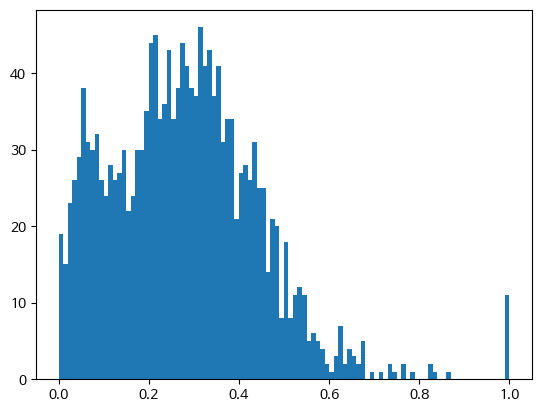

In [25]:
plt.hist([r['bleu-4'] for r in test_results], bins=100);
np.mean([r['bleu-4'] for r in test_results]), np.median([r['bleu-4'] for r in test_results])

In [26]:
"""
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
"""

'\n!sudo apt-get install -y fonts-nanum\n!sudo fc-cache -fv\n!rm ~/.cache/matplotlib -rf\n'

In [27]:
plt.rc('font', family='NanumBarunGothic')

In [28]:
dataset.set_split('val')
batch_generator = generate_nmt_batches(dataset,
                                       batch_size=args.batch_size,
                                       device=args.device)
batch_dict = next(batch_generator)

model = model.eval().to(args.device)
sampler = NMTSampler(vectorizer, model)
sampler.apply_to_batch(batch_dict)

In [29]:
all_results = []
for i in range(args.batch_size):
    all_results.append(sampler.get_ith_item(i, False))

In [30]:
top_results = [x for x in all_results if x['bleu-4']>0.1]
len(top_results)

58

# Attention Visualization

In [31]:
for result_info in top_results:
  print(result_info["source"])
  print(result_info["reference"])
  print(result_info["sampled"])
  print()


['And', 'of', 'course', 'the', 'heartbreaking', 'flip', 'side', 'of', 'this', 'study', 'is', 'that', 'they', 'took', 'the', '``', 'A', 'students', "''", 'and', 'told', 'them', 'they', 'were', '``', 'D', "'s", '.', "''"]
['그리고', '물론', '이', '실험', '의', '한편', '에', '는', '안타깝', 'ㄴ', '면도', '있', '는데요', '.', 'A', '등급', '학생', '들', '에게', 'D', '등급', '의', '열등', '생', '이', '라고', '속', '이', 'ㄴ', '거', 'ㅂ니다', '.']
['그리고', '물론', '이', '연구', '에', '"', '은', '는', '"', 'ㄴ', '것', '이', '는', '.', '"', '"', '에', '들', '은', '"', '를', '"', '"', '"', '이', '었', '부르', '하', 'ㅂ니다', '"', '죠', '.']

['And', 'so', 'in', 'fact', 'we', 'need', 'a', 'big', 'breakthrough', 'here', 'something', 'that', "'s", 'going', 'to', 'be', 'a', 'factor', 'of', '<NUM>', 'better', 'than', 'the', 'approaches', 'we', 'have', 'now', '.']
['바로', '이', '점', '에서', '크', 'ㄴ', '돌파구', '가', '필요', '하', 'ㅂ니다', '.', '우리', '가', '현재', '가지', 'ㄴ', '것', '보다', '백', '배', '이상', '앞서', 'ㄴ', '접근', '이', '있', '어야', '하', 'ㄴ다는', '것', '이', 'ㅂ니다', '.']
['그래서', '우리', '문제', '

<ipython-input-54-f898aa97c865>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

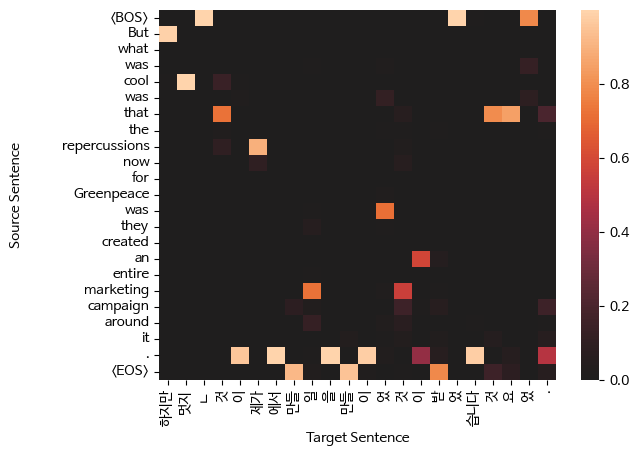

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

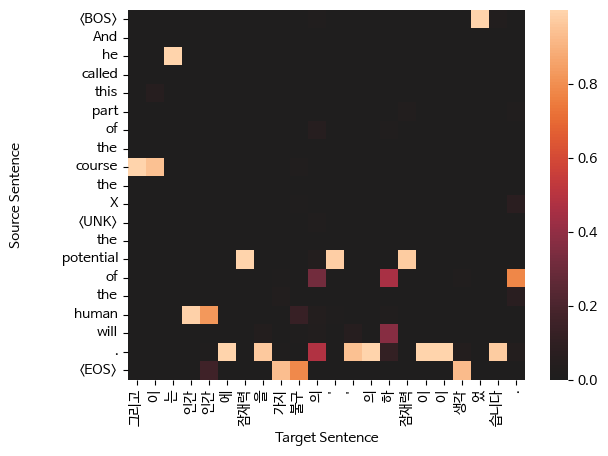

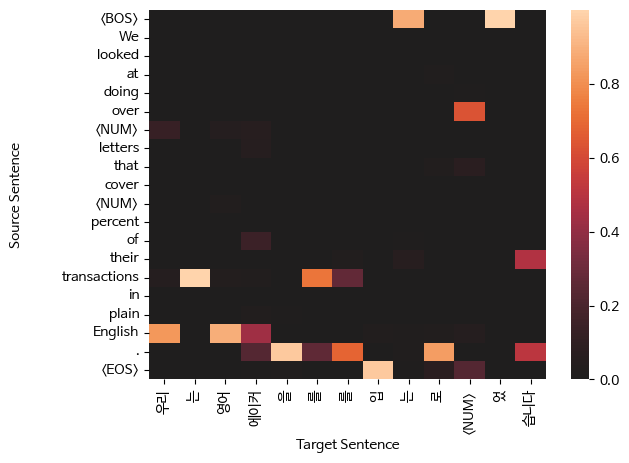

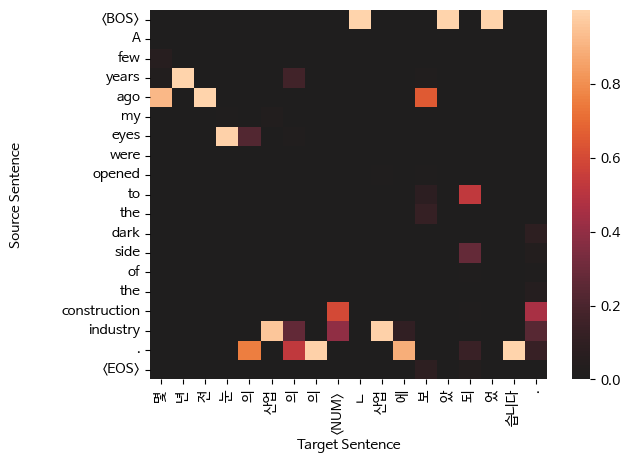

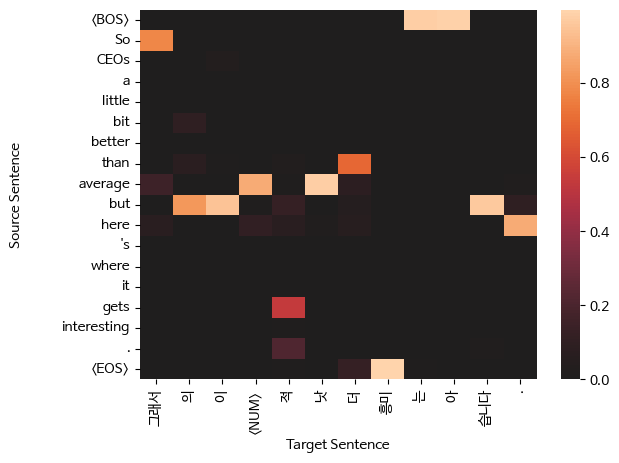

<Figure size 640x480 with 0 Axes>

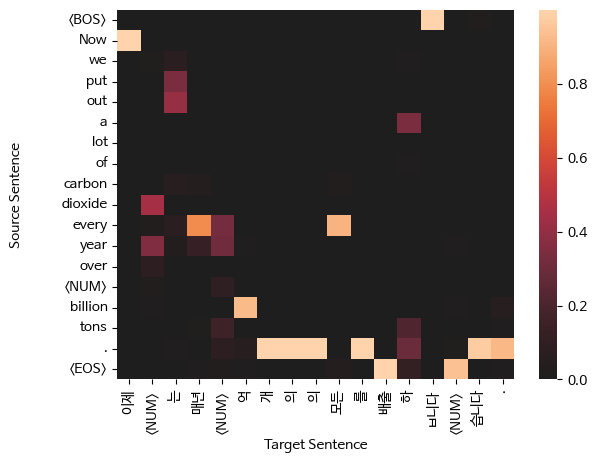

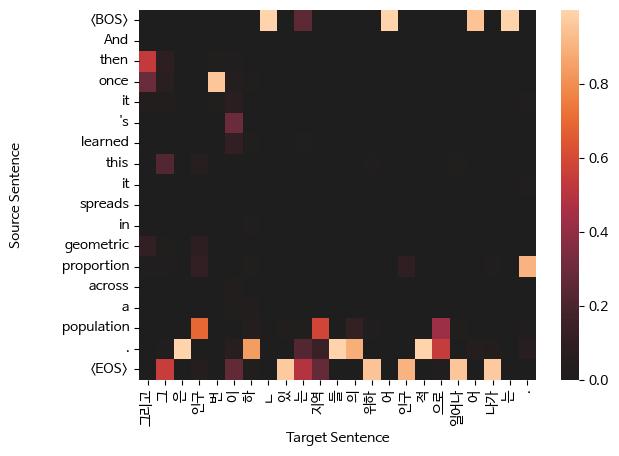

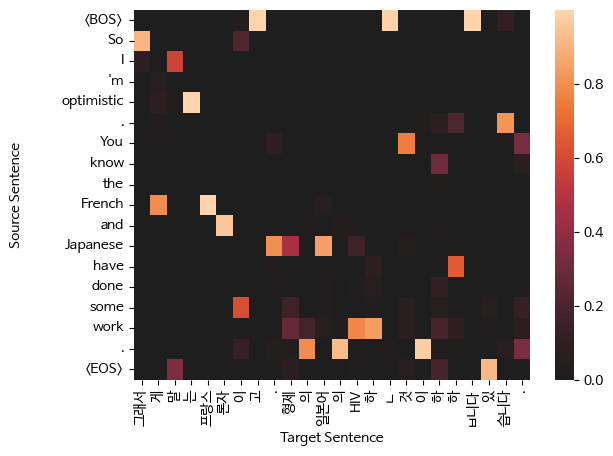

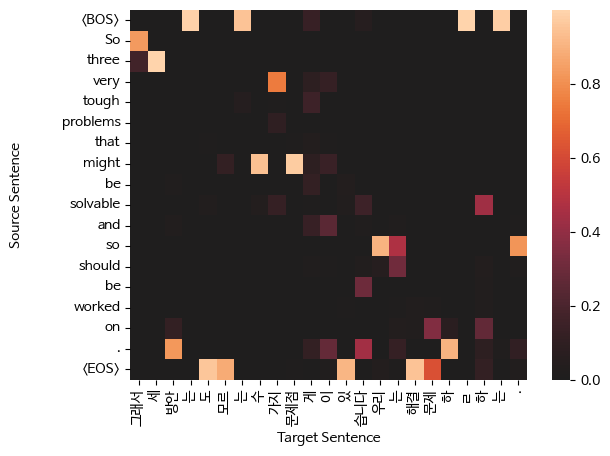

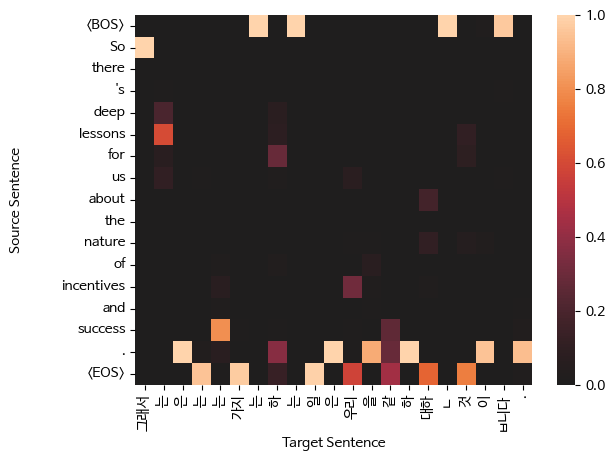

<Figure size 640x480 with 0 Axes>

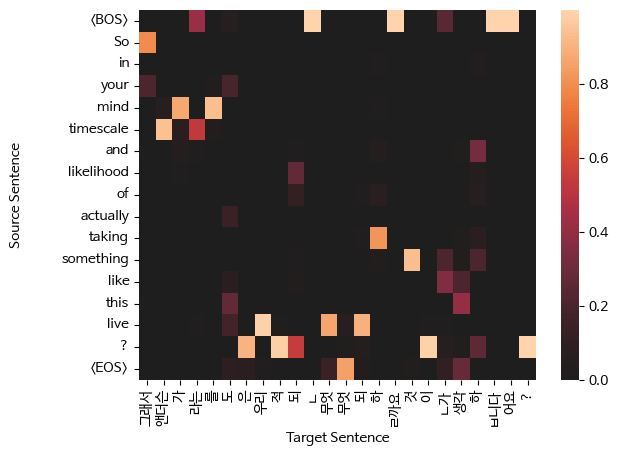

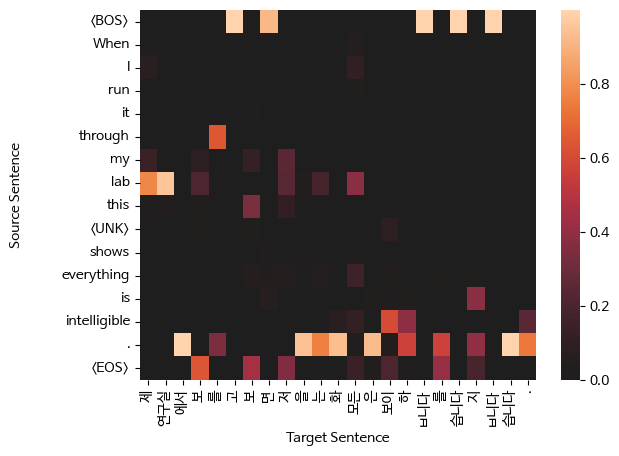

<Figure size 640x480 with 0 Axes>

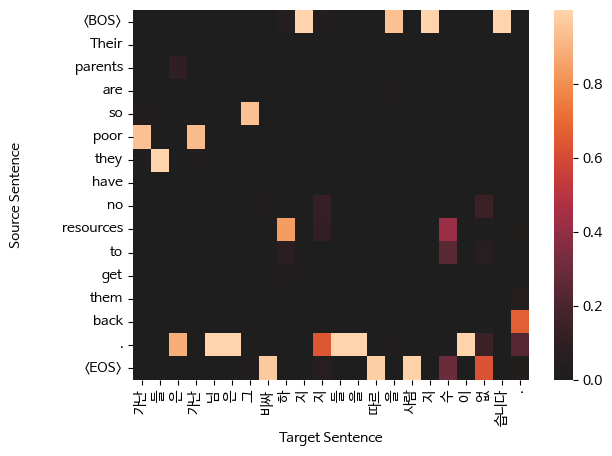

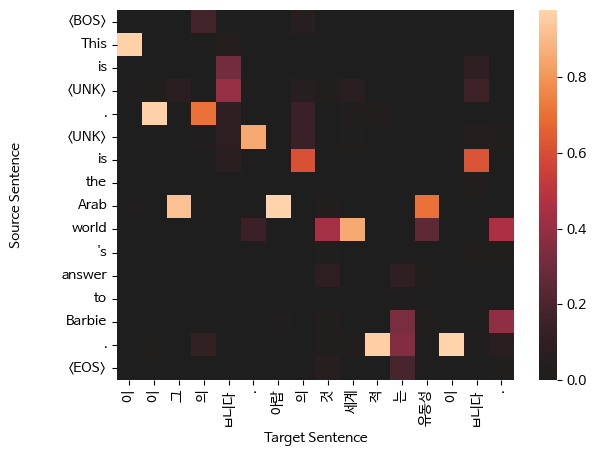

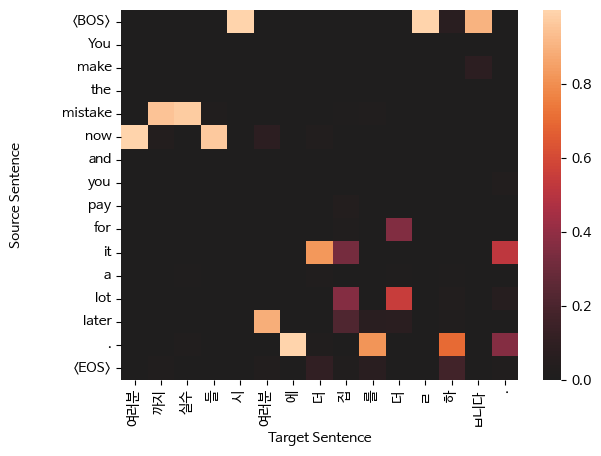

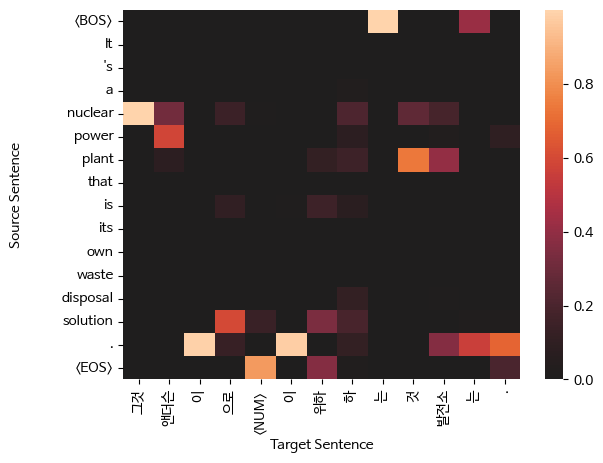

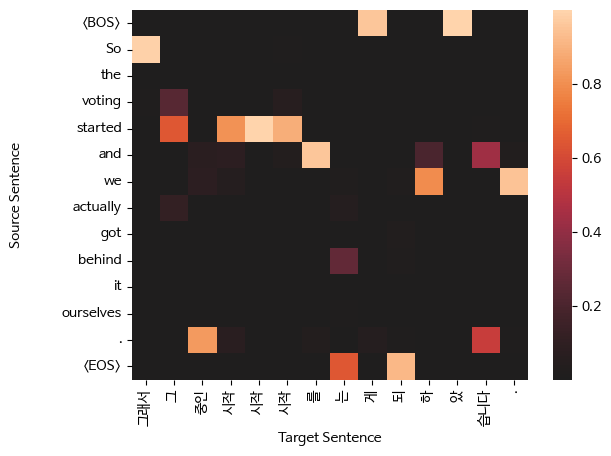

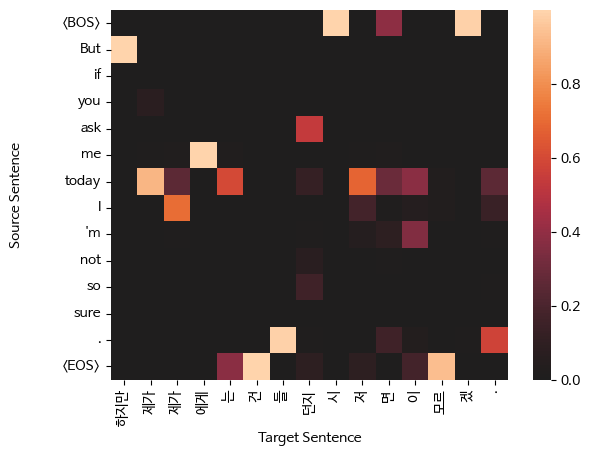

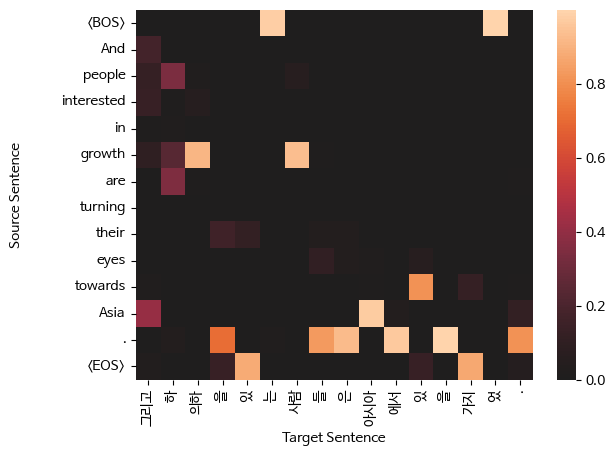

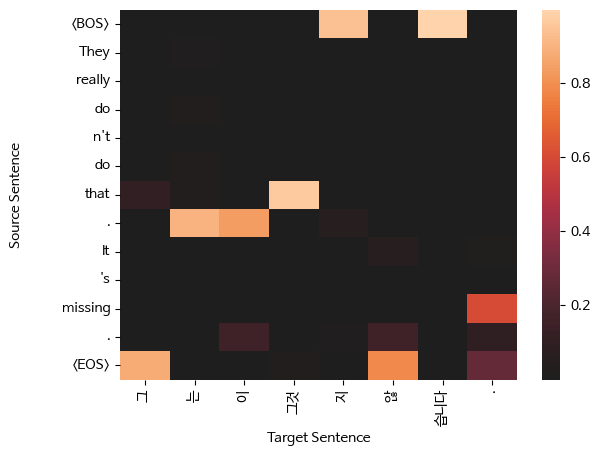

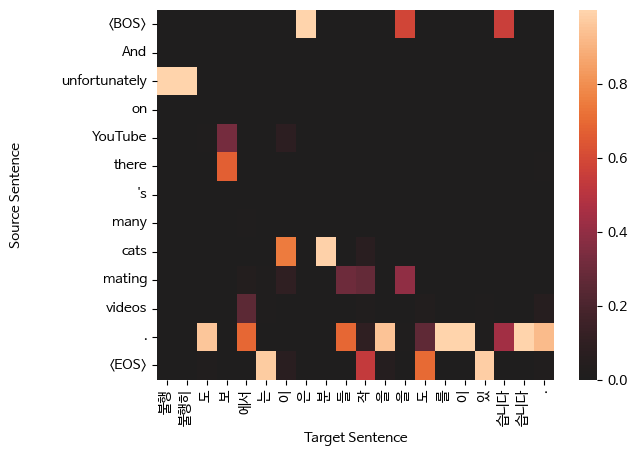

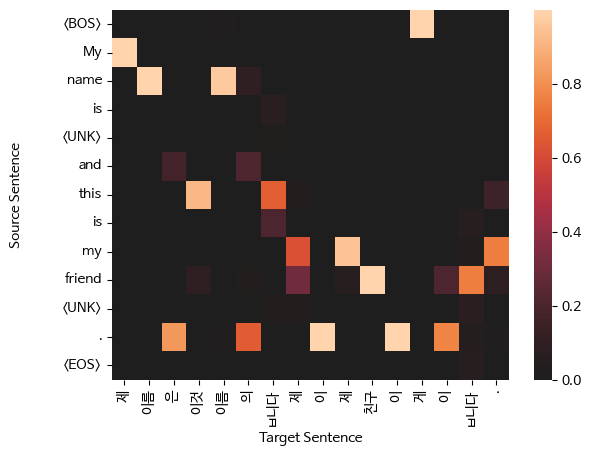

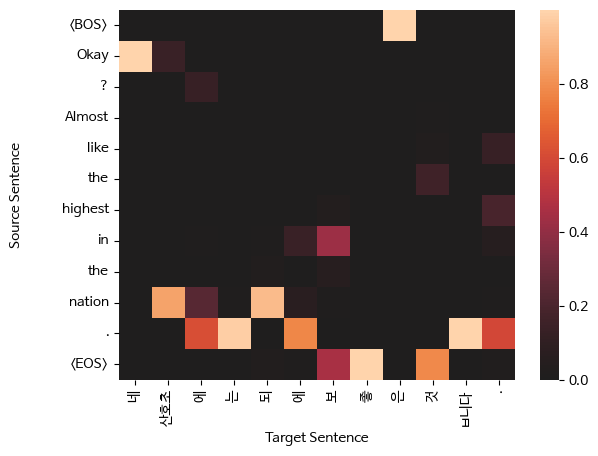

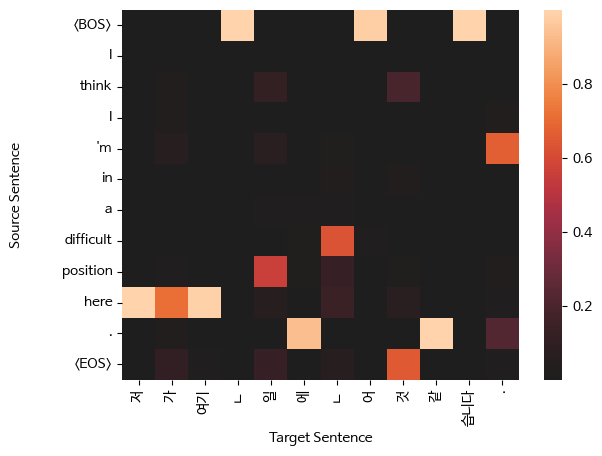

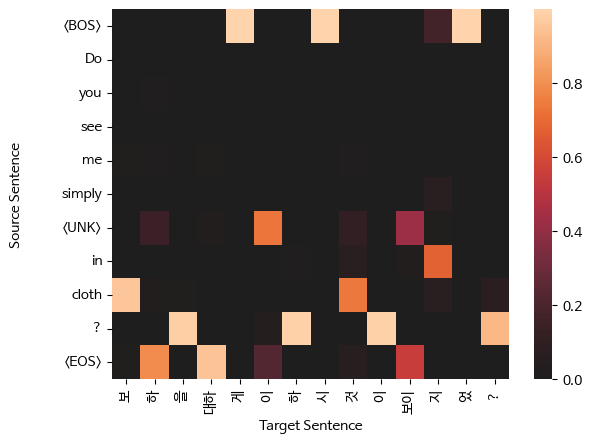

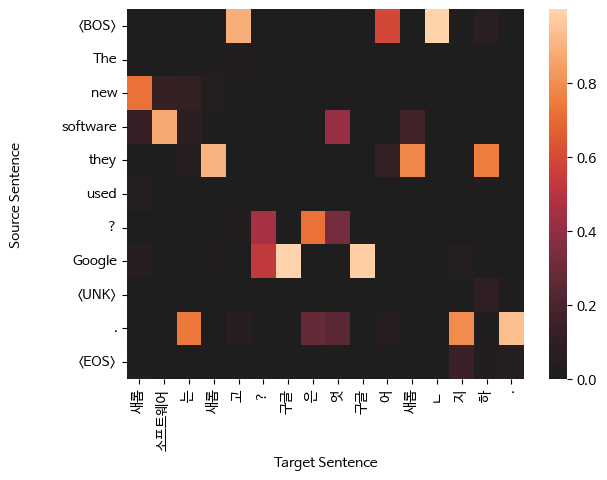

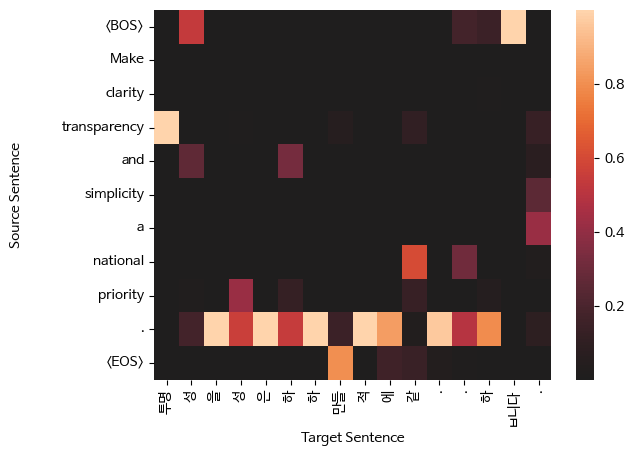

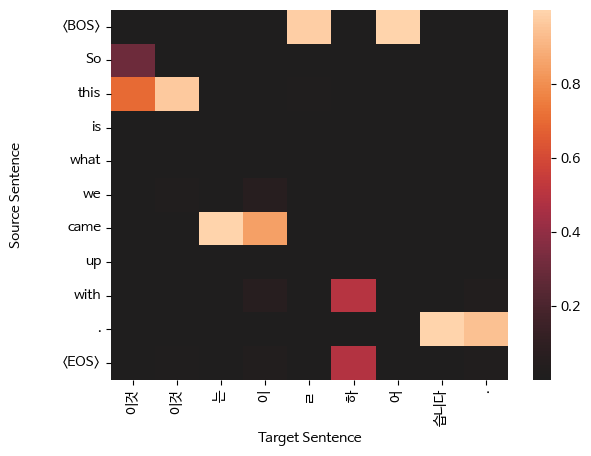

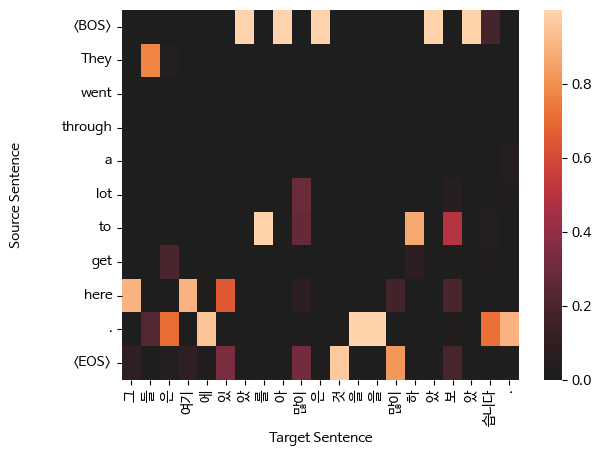

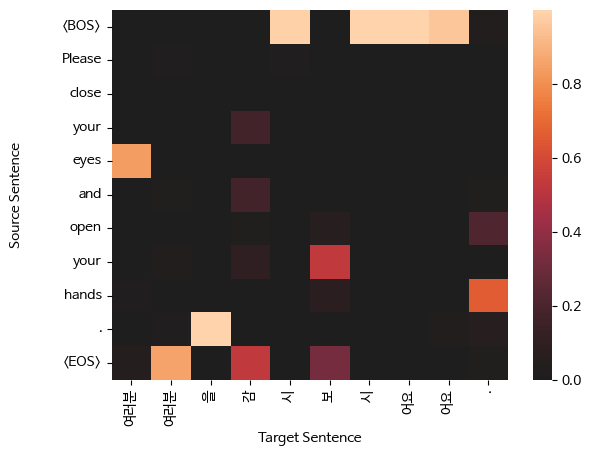

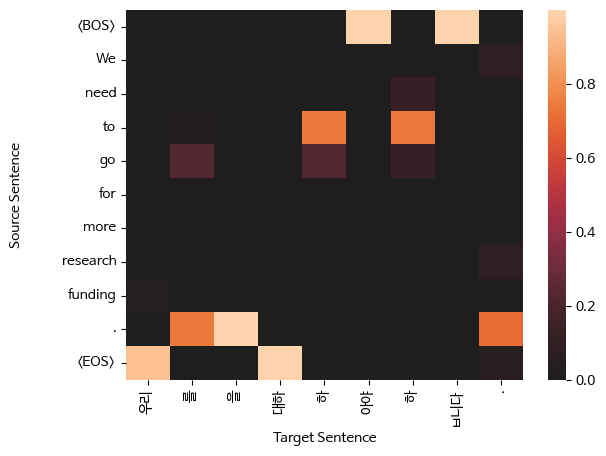

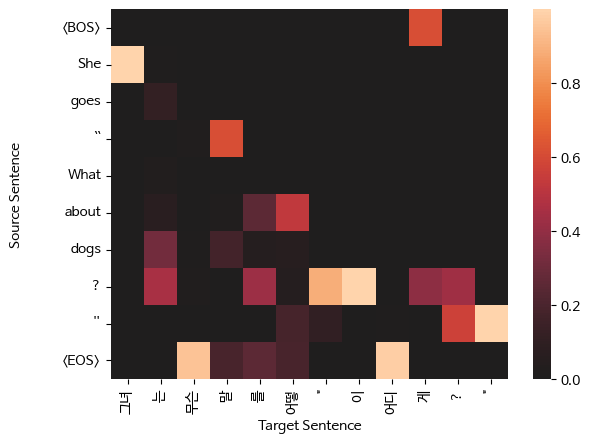

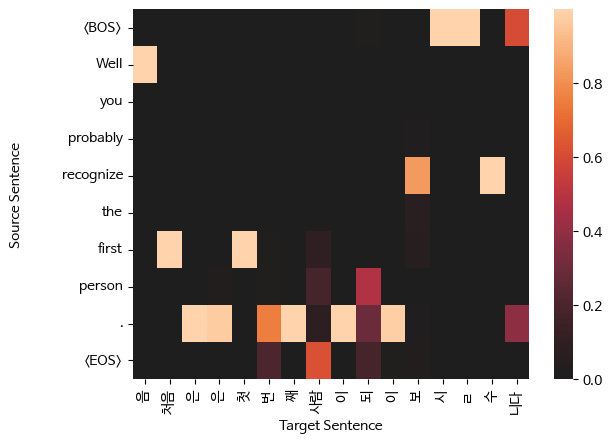

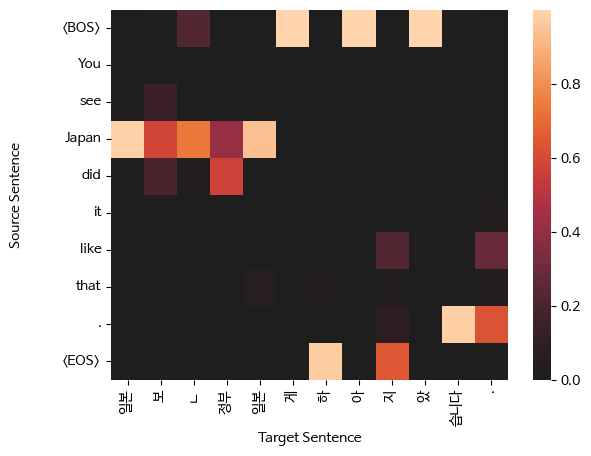

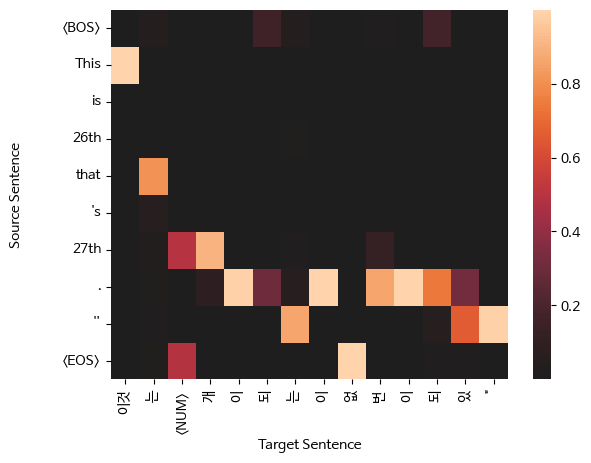

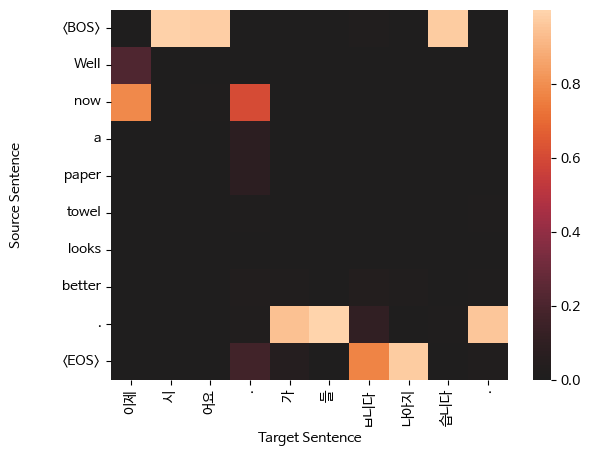

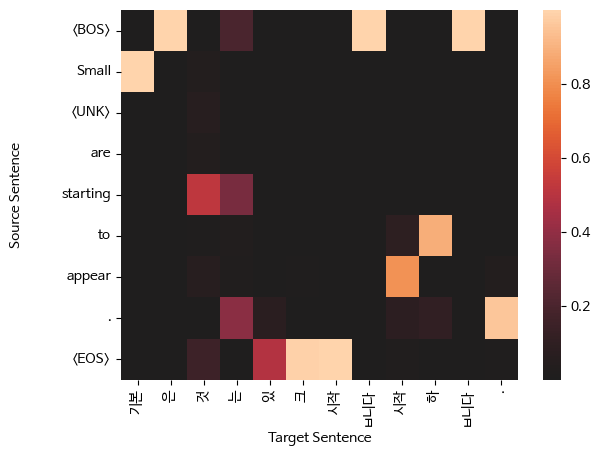

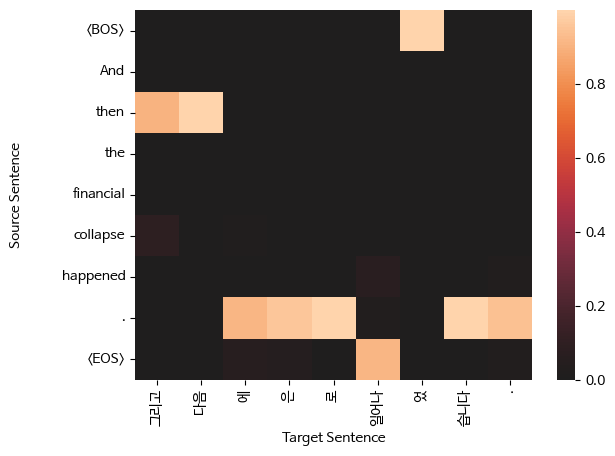

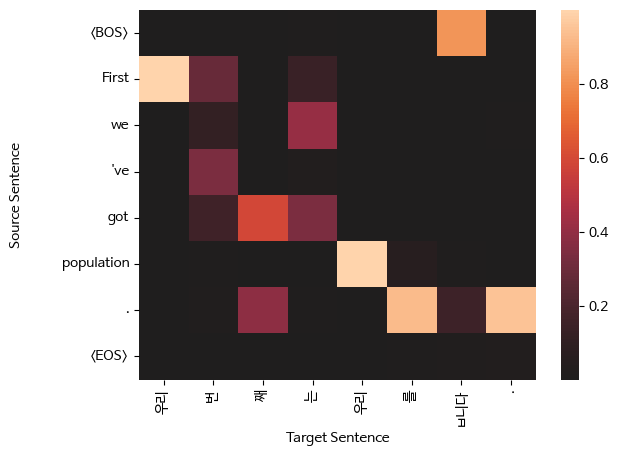

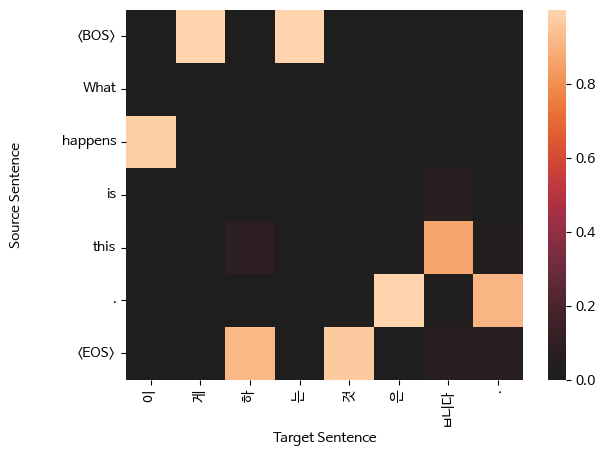

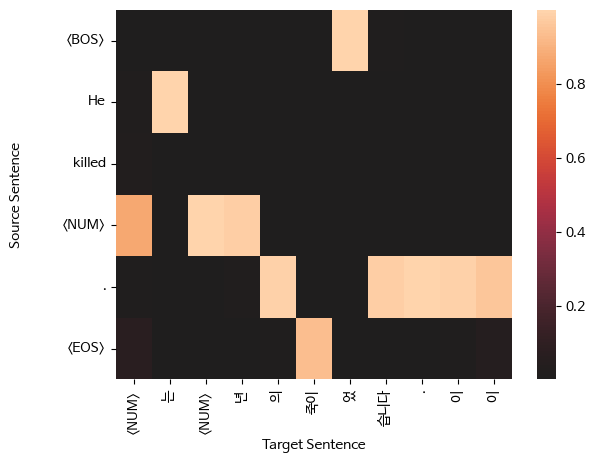

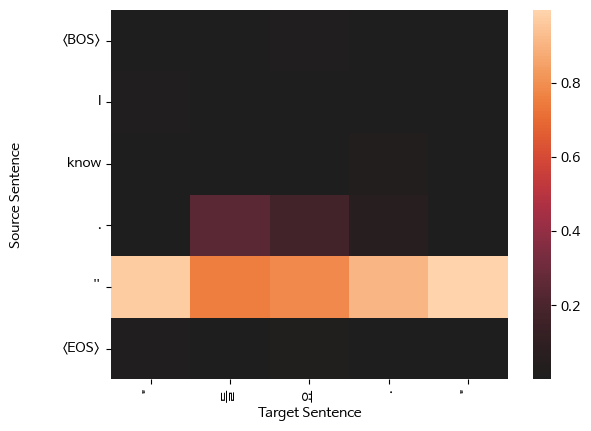

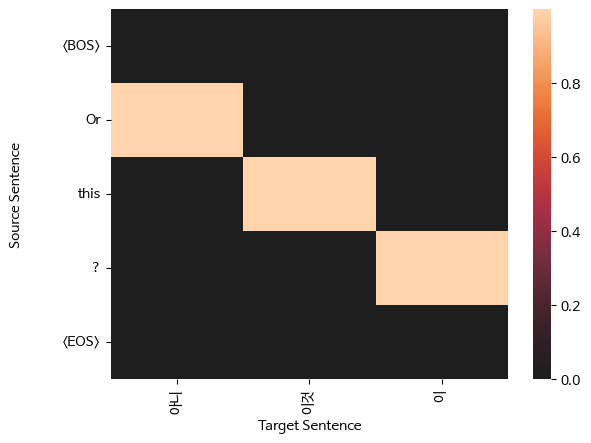

In [54]:

for sample in top_results:
    plt.figure()
    target_len = len(sample['sampled'])
    source_len = len(sample['source'])
    if target_len >= 25 or source_len >= 25:
      continue

    attention_matrix = sample['attention'][:target_len, :source_len+2].transpose()#[::-1]
    ax = sns.heatmap(attention_matrix, center=0.0)
    ylabs = ["<BOS>"]+sample['source']+["<EOS>"]
    #ylabs = sample['source']
    #ylabs = ylabs[::-1]
    ax.set_yticklabels(ylabs, rotation=0)
    ax.set_xticklabels(sample['sampled'], rotation=90)
    ax.set_xlabel("Target Sentence")
    ax.set_ylabel("Source Sentence\n\n")

In [60]:
def get_source_sentence(vectorizer, batch_dict, index):
    indices = batch_dict['x_source'][index].cpu().data.numpy()
    vocab = vectorizer.source_vocab
    return sentence_from_indices(indices, vocab)

def get_true_sentence(vectorizer, batch_dict, index):
    return sentence_from_indices(batch_dict['y_target'].cpu().data.numpy()[index], vectorizer.target_vocab)

def get_sampled_sentence(vectorizer, batch_dict, index):
    y_pred = model(x_source=batch_dict['x_source'],
                   x_source_lengths=batch_dict['x_source_length'],
                   target_sequence=batch_dict['x_target'])
    return sentence_from_indices(torch.max(y_pred, dim=2)[1].cpu().data.numpy()[index], vectorizer.target_vocab)

def get_all_sentences(vectorizer, batch_dict, index):
    return {"source": get_source_sentence(vectorizer, batch_dict, index),
            "truth": get_true_sentence(vectorizer, batch_dict, index),
            "sampled": get_sampled_sentence(vectorizer, batch_dict, index)}

def sentence_from_indices(indices, vocab, strict=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            return " ".join(out)
        else:
            out.append(vocab.lookup_index(index))
    return " ".join(out)

for i in range(20):
  results = get_all_sentences(vectorizer, batch_dict, i)
  print("source: %s" % (results["source"]))
  print("target: %s" % results["sampled"])
  print("truth: %s" % results["truth"])
  print()

source: And of course the heartbreaking flip side of this study is that they took the `` A students '' and told them they were `` D 's . ''
target: 물론 물론 이 사람 들 " 으로 는 " ㄴ 사람 이 습니다 . " " 에 들 이 " " 이 " " 이 ㄴ 부르 하 죠 " 죠 .
truth: 그리고 물론 이 실험 의 한편 에 는 안타깝 ㄴ 면도 있 는데요 . A 등급 학생 들 에게 D 등급 의 열등 생 이 라고 속 이 ㄴ 거 ㅂ니다 .

source: And so in fact we need a big breakthrough here something that 's going to be a factor of <NUM> better than the approaches we have now .
target: 그래서 여기 우리 크 우리 ㄴ 규모 를 필요 하 ㅂ니다 . 여기 는 지금 의 ㄴ 것 보다 더 더 의 이 더 우리 하 되 습니다 하 ㅂ니다 것 이 ㅂ니다 .
truth: 바로 이 점 에서 크 ㄴ 돌파구 가 필요 하 ㅂ니다 . 우리 가 현재 가지 ㄴ 것 보다 백 배 이상 앞서 ㄴ 접근 이 있 어야 하 ㄴ다는 것 이 ㅂ니다 .

source: So I 'd very much like to see us begin to really seize this as an opportunity to get this into our medical records .
target: 그래서 저 의 의료 의학 위하 하 하 대하 적 으로 를 만들 하 고 위하 아 기회 를 하 어 습니다 하 았 .
truth: 그리고 우리 는 이 를 의료 기록 에 지리 적 정보 를 추가 하 기 위하 ㄴ 기회 로 받아들이 었 으면 하 ㅂ니다 .

source: And I think it 's very unlikely that they were far from the minds of Americans 

In [61]:
import pickle

with open(args.train_state_file, "wb") as f:
  pickle.dump(train_state, f)